In [ ]:
# import os
# !git clone https://github.com/aldo-fsm/fake-news-detection.git
# os.chdir('fake-news-detection')
# # !pip install pipfile-requirements
# # !pipfile2req > requirements.txt
# # !pip install -r requirements.txt
# !pip install ktrain
# ! mkdir models && mv ../SVM_rbf_20000feat_acc_0.909741 ./models/

In [8]:
%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from IPython.display import display
import plotly_express as px
import plotly.io as pio
pio.renderers.default = 'colab'

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
from preprocessing import stopwords, preprocess, putEndDot
from datasets import fake_br_corpus

In [14]:
dataset = fake_br_corpus.loadTrain(True)
dataset['text'] = dataset.text.apply(putEndDot)

In [15]:
import joblib
model = joblib.load('models/SVM_rbf_20000feat_acc_0.909741')

In [16]:
from preprocessing.sentence_ranking_transformer import SentenceRankingTransformer
ranker = SentenceRankingTransformer(model, 'fake')

In [17]:
dataset['rankedText'] = ranker.fit_transform(dataset.text)

In [18]:
import ktrain
from ktrain import text

In [19]:
dataset[['isFake', 'isTrue']] = dataset.label.apply(lambda label: pd.Series([1,0]) if label == 'fake' else pd.Series([0,1]))

In [20]:
trn, val, preproc = text.texts_from_df(
  dataset,
  text_column='rankedText',
  label_columns=['isFake', 'isTrue'], 
  maxlen=512, 
  preprocess_mode='bert',
)

['isFake', 'isTrue']
      isFake  isTrue
4208       1       0
1535       0       1
3287       0       1
2507       0       1
866        1       0
['isFake', 'isTrue']
      isFake  isTrue
4909       0       1
1395       0       1
789        0       1
1378       1       0
3830       1       0
downloading pretrained BERT model (multi_cased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: pt


Is Multi-Label? False
preprocessing test...
language: pt


In [28]:
model = text.text_classifier('bert', trn , preproc=preproc)

Is Multi-Label? False
maxlen is 512
done.


In [29]:
learner = ktrain.get_learner(
  model, 
  train_data=trn, 
  val_data=val, 
  batch_size=6,
)

In [30]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
914/914 [==============================] - 1184s 1s/step - loss: 0.6053 - accuracy: 0.6291
Epoch 2/1024
914/914 [==============================] - 592s 647ms/step - loss: 2.0174 - accuracy: 0.5011


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


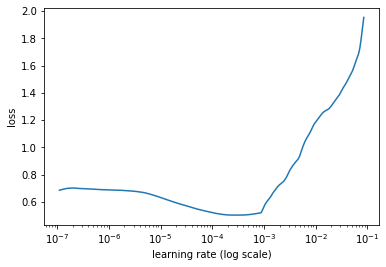

In [31]:
learner.lr_plot()

In [32]:
history = learner.fit_onecycle(2e-5, 1)



begin training using onecycle policy with max lr of 2e-05...
914/914 [==============================] - 1137s 1s/step - loss: 0.2416 - accuracy: 0.8877 - val_loss: 0.1000 - val_accuracy: 0.9525


In [33]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [34]:
model.save('model')

In [35]:
predictor.save('predictor')

In [38]:
!cp -r model ../drive/MyDrive/

In [39]:
!cp -r predictor ../drive/MyDrive/

---

In [42]:
history2 = learner.fit_onecycle(2e-5, 5)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/5
914/914 [==============================] - 1129s 1s/step - loss: 0.0574 - accuracy: 0.9799 - val_loss: 0.1191 - val_accuracy: 0.9525
Epoch 2/5
914/914 [==============================] - 1129s 1s/step - loss: 0.0715 - accuracy: 0.9750 - val_loss: 0.1475 - val_accuracy: 0.9393
Epoch 3/5
914/914 [==============================] - 1126s 1s/step - loss: 0.0497 - accuracy: 0.9796 - val_loss: 0.0905 - val_accuracy: 0.9705
Epoch 4/5
914/914 [==============================] - 1124s 1s/step - loss: 0.0184 - accuracy: 0.9942 - val_loss: 0.1057 - val_accuracy: 0.9754
Epoch 5/5
914/914 [==============================] - 1124s 1s/step - loss: 0.0028 - accuracy: 0.9989 - val_loss: 0.1074 - val_accuracy: 0.9754


In [43]:
model.save('model2')
!cp -r model2 ../drive/MyDrive/

In [44]:
predictor2 = ktrain.get_predictor(learner.model, preproc)

In [45]:
predictor2.save('predictor2')
!cp -r predictor2 ../drive/MyDrive/

In [46]:
history2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr', 'iterations', 'momentum'])

In [47]:
historyDf = pd.DataFrame(dict(
  loss=history2.history['loss'],
  accuracy=history2.history['accuracy'],
  val_loss=history2.history['val_loss'],
  val_accuracy=history2.history['val_accuracy'],
))

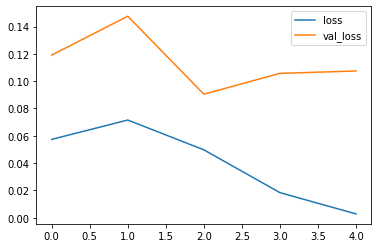

In [48]:
historyDf[['loss', 'val_loss']].plot()

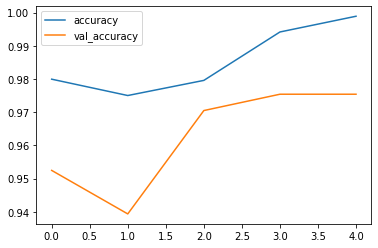

In [49]:
historyDf[['accuracy', 'val_accuracy']].plot()

In [ ]:
from utils import evaluation

In [ ]:
evaluation.sizeDistributionByLabel(dataset.label, dataset.rankedText.apply(lambda text: len(text.split(' '))))

In [52]:
predictor.predict(['''POLICIA Civil informa SE VOCÊ TIVER INFORTÚNIO DE SER VÍTIMA DE UM SEQÜESTRO-RELÂMPAGO, E TIVER QUE SACAR DINHEIRO NUM CAIXA ELETRÔNICO, MANTENHA A CALMA E TECLE SUA SENHA DE MANEIRA INVERSA'''])

['isFake']

In [59]:
predictor.predict(['''POLICIA Civil informa SE VOCÊ TIVER INFORTÚNIO DE SER VÍTIMA DE UM SEQÜESTRO-RELÂMPAGO, E TIVER QUE SACAR DINHEIRO NUM CAIXA ELETRÔNICO, MANTENHA A CALMA E TECLE SUA SENHA DE MANEIRA INVERSA.'''])

['isTrue']

In [ ]:
dataset[dataset.label == 'fake'].rankedText.apply(lambda text: text.strip()[-1]).value_counts()

In [ ]:
dataset[dataset.label == 'true'].rankedText.apply(lambda text: text.strip()[-1]).value_counts()